In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, firwin, lfilter, filtfilt, freqz
from scipy.fft import fft
from scipy import pi, signal

data_path = './s1_s1_ec.csv'

df = pd.read_csv(data_path)

display(df.head())
print(f'Dimensi Data: {df.shape}')

,F3,FC5,AF3,F7,T7,P7,O1,O2,P8,T8,F8,AF4,FC6,F4,Timestamp,Date,Time
0,4197.948718,4173.974359,4187.564102,4187.051282,4196.153846,4199.230769,4185.000000,4203.589744,4204.871795,4195.512820,4156.666666,4199.487179,4187.564102,4199.102564,14-04-2018 12:01:43.828,14-04-2018,12:01:43.828
1,4199.102564,4172.564102,4190.128205,4176.282051,4188.461538,4202.820513,4186.282051,4202.692308,4203.974359,4198.333333,4185.769231,4192.820513,4185.000000,4198.461538,14-04-2018 12:01:43.828,14-04-2018,12:01:43.828
2,4190.512820,4171.666667,4184.615384,4185.769231,4186.538461,4202.692308,4186.923077,4198.846154,4199.871795,4187.051282,4200.897436,4180.000000,4185.641026,4189.871795,14-04-2018 12:01:43.831,14-04-2018,12:01:43.831
3,4189.615384,4168.717949,4186.666667,4182.820513,4187.692308,4195.769231,4185.897436,4198.589743,4201.410256,4183.846154,4166.923077,4198.333333,4191.025641,4198.846154,14-04-2018 12:01:43.832,14-04-2018,12:01:43.832
4,4198.846154,4176.666667,4193.205128,4184.230769,4184.743590,4202.051282,4189.743590,4203.846154,4203.461538,4198.846154,4196.666667,4194.743590,4193.846154,4196.923077,14-04-2018 12:01:43.832,14-04-2018,12:01:43.832


Dimensi Data: (30720, 17)


In [158]:
dataRAW = df.to_dict('dict')
dataHASIL = pd.DataFrame(data={"AF3":dataRAW["AF3"], "AF4":dataRAW["AF4"], "O1":dataRAW["O1"], "O2":dataRAW["O2"] })

display(dataHASIL.head())

,AF3,AF4,O1,O2
0,4187.564102,4199.487179,4185.000000,4203.589744
1,4190.128205,4192.820513,4186.282051,4202.692308
2,4184.615384,4180.000000,4186.923077,4198.846154
3,4186.666667,4198.333333,4185.897436,4198.589743
4,4193.205128,4194.743590,4189.743590,4203.846154


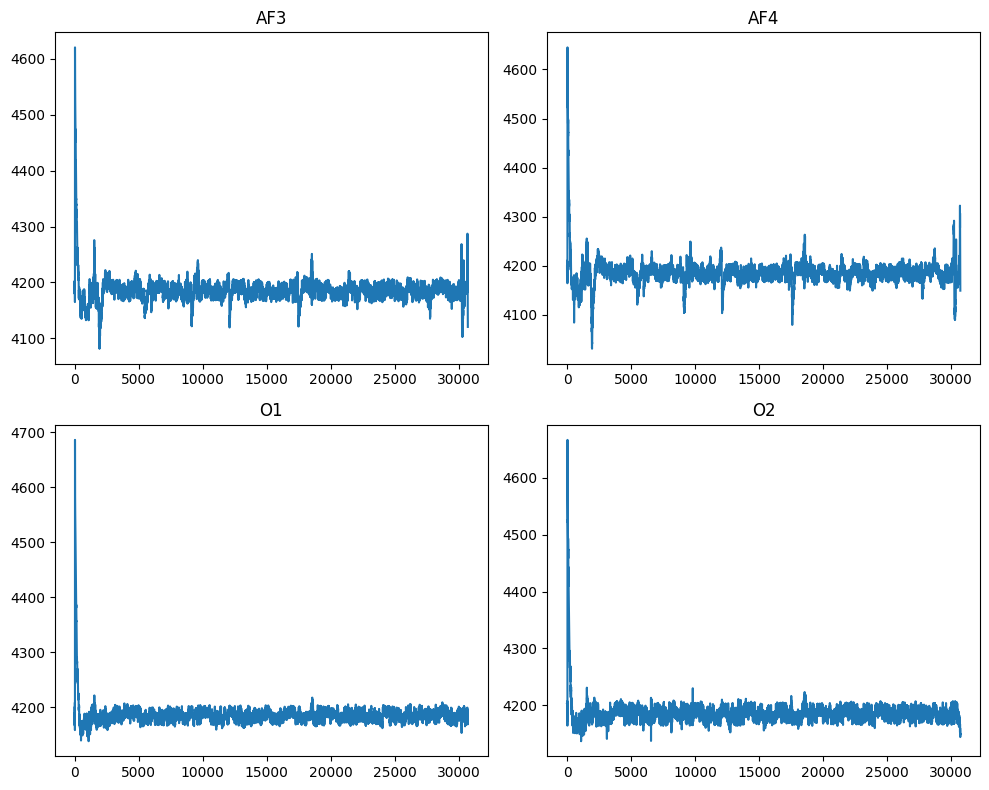

In [159]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(dataHASIL["AF3"])
axs[0, 0].set_title('AF3')

axs[0, 1].plot(dataHASIL["AF4"])
axs[0, 1].set_title('AF4')

axs[1, 0].plot(dataHASIL["O1"])
axs[1, 0].set_title('O1')

axs[1, 1].plot(dataHASIL["O2"])
axs[1, 1].set_title('O2')

plt.tight_layout()
plt.show()

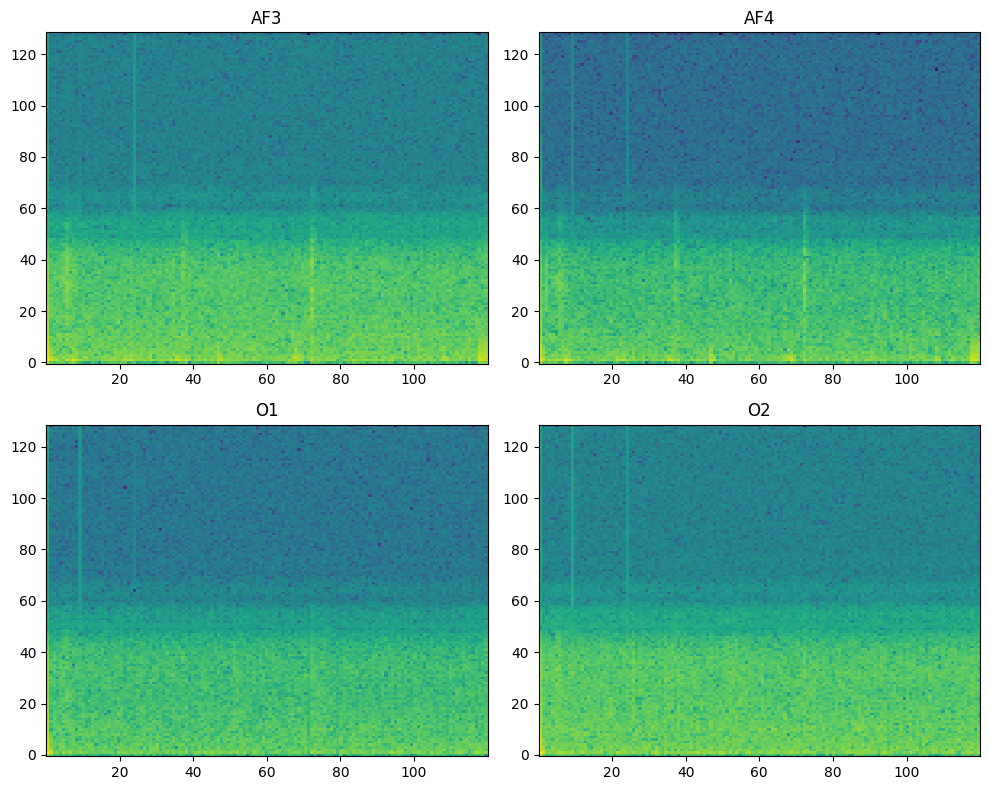

In [160]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

dataTEMP = [["AF3","AF4"],["O1","O2"]]

for i in range(len(dataTEMP)) :
    for j in range(len(dataTEMP[i])) :
        frequencies, times, spectrogram = signal.spectrogram(dataHASIL[dataTEMP[i][j]].values, fs=256)

        axs[i, j].pcolormesh(times, frequencies, 10 * np.log10(spectrogram), shading='auto')
        axs[i, j].set_title(dataTEMP[i][j])

plt.tight_layout()
plt.show()

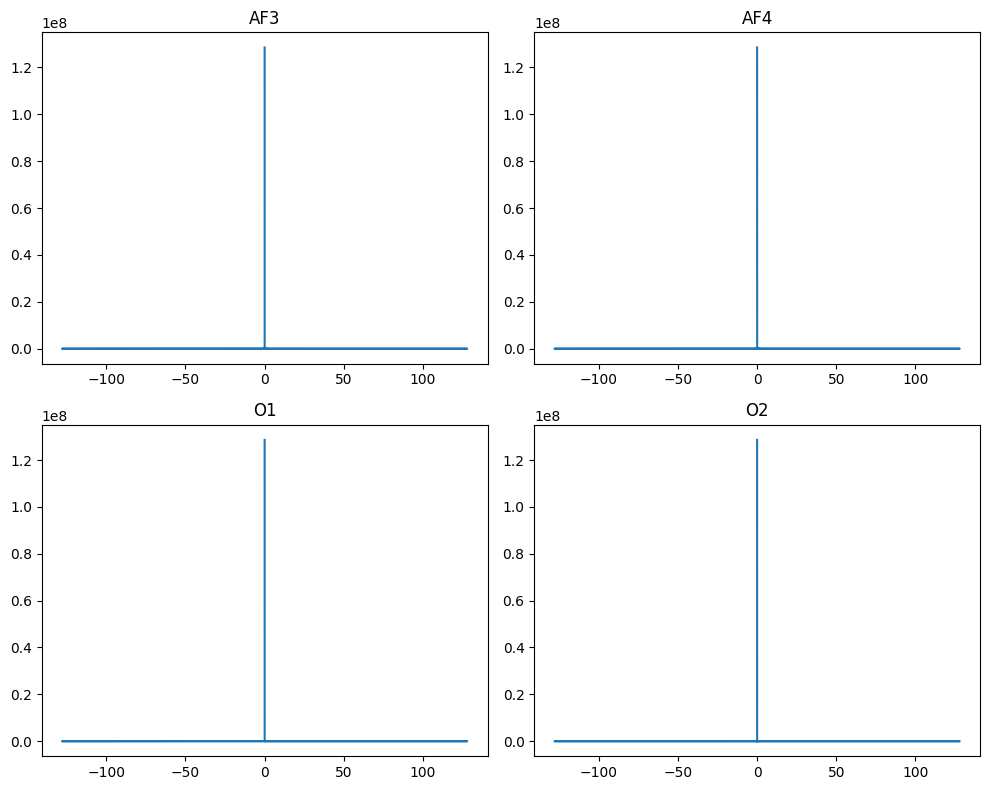

In [161]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

dataTEMP = [["AF3","AF4"],["O1","O2"]]

for i in range(len(dataTEMP)) :
    for j in range(len(dataTEMP[i])) :
        N = len(dataHASIL[dataTEMP[i][j]].values)
        fs = 256
        frequencies = np.fft.fftfreq(N, 1/fs)
        fft_result = fft(dataHASIL[dataTEMP[i][j]].values)

        axs[i, j].plot(frequencies, np.abs(fft_result))
        axs[i, j].set_title(dataTEMP[i][j])

plt.tight_layout()
plt.show()